# Precise Surface Profiling at the Nanoscale Enabled by Deep Learning  
Lalith Krishna Samanth Bonagiri (1,2), Zirui Wang (3), Shan Zhou (1,3), and Yingjie Zhang (1,3)*    
1. Materials Research Laboratory, University of Illinois, Urbana, Illinois 61801, USA
2. Department of Mechanical Science and Engineering, University of Illinois, Urbana, Illinois 61801, USA
3. Department of Materials Science and Engineering, University of Illinois, Urbana, Illinois 61801, USA
*Correspondence to: yjz@illinois.edu


In [1]:
# Import required modules

# Data loading, plotting, and dataset generation
import numpy as np
import pandas as pd
import os
import math
import random
from math import sqrt
import matplotlib.pyplot as plt
import scipy
from scipy import ndimage
from scipy import io
from skimage.draw import random_shapes
from PIL import Image

# Dataset manipulation
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# Deep learning model
import keras
import tensorflow as tf
from keras.models import Sequential, Model, load_model
from keras.layers import Activation, Input, Convolution2D, MaxPooling2D, UpSampling2D

# Data saving
from scipy.io import savemat

In [2]:
tf.device('GPU')

# **Part I: Generation of Artifacts on Experimental STM Dataset**

In [3]:
!git clone https://github.com/nickkolev97/Tip_deconvolution_hackathon.git

Cloning into 'Tip_deconvolution_hackathon'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 41 (delta 0), reused 0 (delta 0), pack-reused 40 (from 1)
Receiving objects: 100% (41/41), 122.72 MiB | 15.21 MiB/s, done.
Resolving deltas: 100% (6/6), done.
Updating files: 100% (15/15), done.


## **Generate the ground-truth and tip-convoluted images**


Loading tip to generate images with artifacts

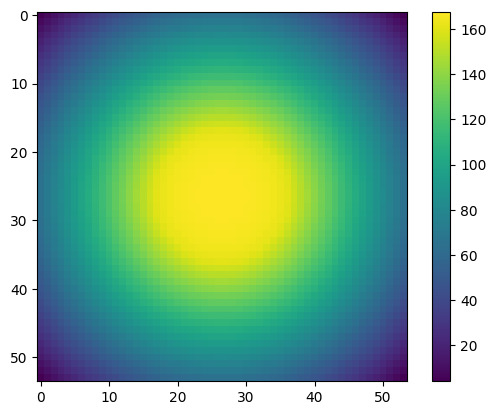

In [6]:
# Import tip
tip = io.loadmat("tip")
tip_shape = tip['tip_tip']*1e9
plt.imshow(tip_shape)
plt.colorbar()

In [7]:
train_p0 = np.load('/content/Tip_deconvolution_hackathon/data/filled_empty/train_imgs_0.npy')
train_p1 = np.load('/content/Tip_deconvolution_hackathon/data/filled_empty/train_imgs_1.npy')
train_imgs = np.concatenate((train_p0, train_p1), axis=0)

In [8]:
ground_truth_imgs_list = []
dilated_imgs_list = []
dilated_imgs = np.zeros((1200, 128, 128))
ground_truth_imgs = np.zeros((1200, 128, 128))
for i in range(1200):
  ground_truth_imgs[i,:,:] = train_imgs[i,:,:]
  dilated_imgs[i,:,:] = scipy.ndimage.grey_dilation(train_imgs[i,:,:],structure = tip_shape)
  ground_truth_imgs_list.append(ground_truth_imgs[i,:,:])
  dilated_imgs_list.append(dilated_imgs[i,:,:])


dilated_imgs = np.stack(dilated_imgs_list, axis = 0)
ground_truth_imgs = np.stack(ground_truth_imgs_list, axis = 0)

np.save('dilated_imgs.npy', dilated_imgs)
np.save('ground_truth_imgs.npy', ground_truth_imgs)

## **Simulating Line-like and Edge-lift artifacts**

### **The following code may be executed if simulating line-like or edge-lift artifacts are necessary. Note that the remainder of the code needs to be modified accordingly.**

Adding line-like artifacts

In [9]:
# Adding line-like artifacts on processed-dilated images (post dilation and preprocessing steps)
def line_artifact_adder(image_data, image_size):
    processed_images_l = []
    for image in image_data:
        processed_image = image + np.full((128, 128), -167.73) # Background subtraction for the convoluted images
        line_picker = np.random.random((128, 1))
        line_picker = line_picker>0.05
        preserved_lines = np.ones((128,128))*line_picker
        processed_image = processed_image*preserved_lines
        processed_images_l.append(processed_image.reshape(image_size[0], image_size[1], 1))
    processed_images_a = np.stack(processed_images_l, axis=0)
    return processed_images_a

In [10]:
dilated_imgs = np.load('dilated_imgs.npy').astype('float32')

target_size = (128,128)
dilated_imgs_line_artifact = line_artifact_adder(dilated_imgs, target_size)
np.save('dilated_imgs_line_artifact.npy', dilated_imgs_line_artifact)

Adding edge-lift artifact: Note that, to add edge-lift we first modify the ground truth and then apply dilation

In [11]:
# Adding edge-lift to the true images to create more artifacts (prior to dilation)

def edge_lifter(image_data, image_size):
    processed_images_l = []
    for image in image_data:
        processed_image = image

        # Detect the edges
        img = image.astype(np.uint8) #Required for using cv2.Laplacian
        laplacian = cv2.Laplacian(img,cv2.CV_64F) #cv2.Laplacian detects the edges
        laplacian2 = laplacian<0 #cv2.Laplacian has some issues (creates some gradient like feature at the edge), this line of code corrects it.

        #raise the edges by a pixel or higher?
        processed_image = image + laplacian2*1 #raised by 1 nm
        processed_images_l.append(processed_image.reshape(image_size[0], image_size[1]))
    processed_images_a = np.stack(processed_images_l, axis=0)
    return processed_images_a

## **Prepare simulated dataset for the DL model**

First, we load the saved simulated images, which are already paired since the ground-truth and tip-convoluted images are saved together. Then, we split the entire dataset into a training dataset (with 80% of the images) and a testing dataset (with the remaining 20% of the images). Finally, we preprocess the images in both of the training and testing dataset.

In [12]:
# Load the images

training_images_path = 'ground_truth_imgs.npy'
dilated_images_path = 'ground_truth_imgs.npy'


X = np.load(training_images_path).astype('float32')
y = np.load(dilated_images_path).astype('float32')


# Split the entire dataset to training and testing dataset.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Shuffle the training dataset only to help improve the model's preformance
X_train, y_train = shuffle(X_train, y_train)

print("Training data loaded.", "\nno. of images in the training set:", str(X_train.shape[0]),
      "\nno. of images in the testing set:", str(X_test.shape[0]),
      "\nresolution of each image:", str((X_train.shape[1], X_train.shape[2])))

Training data loaded. 
no. of images in the training set: 960 
no. of images in the testing set: 240 
resolution of each image: (128, 128)


In [13]:
import cv2
target_size = (128,128)
edge_lifted_imgs = edge_lifter(y, target_size)
np.save('edge_lifted_imgs.npy',edge_lifted_imgs)

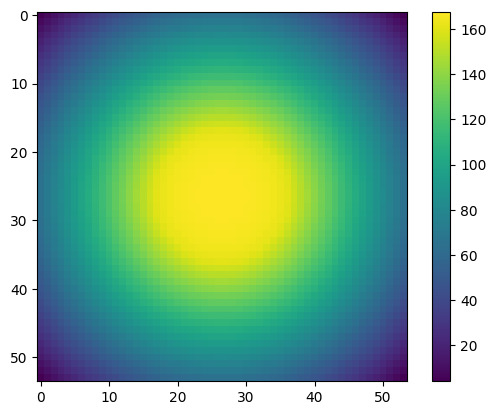

In [14]:
tip = io.loadmat("tip")
tip_shape = tip['tip_tip']*1e9
plt.imshow(tip_shape)
plt.colorbar()

In [15]:
# Dilating the edge-lifted imgs

edge_lifted_imgs = np.load('edge_lifted_imgs.npy').astype('float32')

list_dilated_image = []

for i in range(1200):
  edge_lifted_img = edge_lifted_imgs[i,:,:]
  dilated_img = scipy.ndimage.grey_dilation(edge_lifted_img,structure=tip_shape)
  list_dilated_image.append(dilated_img)

dilated_edge_lifted_imgs = np.stack(list_dilated_image, axis = 0)

np.save('dilated_edge_lifted_imgs.npy', dilated_edge_lifted_imgs)

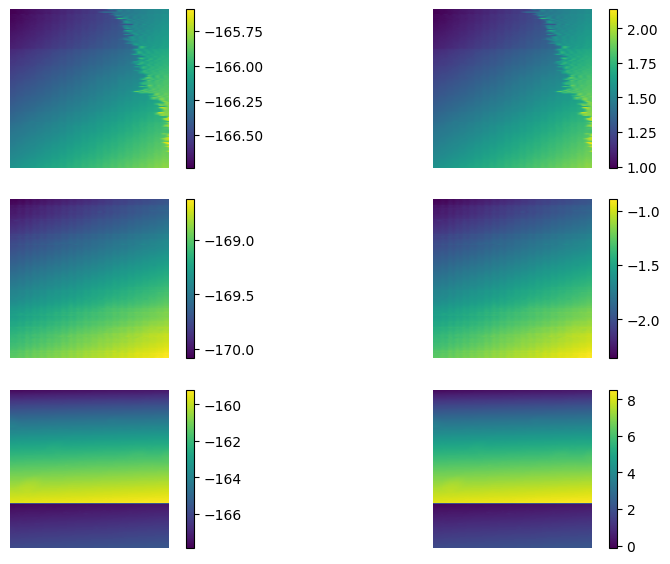

In [16]:
# Height correction of tip-convoluted images (Here we are mainly only correcting some height offset issue due to "Scipy.ndimage.dilation")
# NO normalization or standardization steps

# Preprocessing for the tip-convoluted images

def height_correcter_X(image_data, image_size):
    processed_images_l = []
    for image in image_data:
        processed_image = image + np.full((128, 128), -167.73) # Background subtraction for the convoluted images
        processed_images_l.append(processed_image.reshape(image_size[0], image_size[1], 1))
    processed_images_a = np.stack(processed_images_l, axis=0)
    return processed_images_a

# preprocessing for the ground-truth images (Just reshaping the image data matrix)

def preprocessing_Y(image_data, image_size):
    processed_images_l = []
    for image in image_data:
        processed_image = image
        processed_images_l.append(processed_image.reshape(image_size[0], image_size[1], 1))

    processed_images_a = np.stack(processed_images_l, axis=0)
    return processed_images_a

# Apply the preprocessing functions

nb_classes = 2
target_size = (128, 128)

X_processed_train = height_correcter_X(X_train, target_size)
X_processed_test = height_correcter_X(X_test, target_size)
y_processed_train = preprocessing_Y(y_train, target_size)
y_processed_test = preprocessing_Y(y_test, target_size)

# Show the processed images with scale

fig = plt.figure(figsize=(10, 7))
rows = 3
columns = 2

fig.add_subplot(rows, columns, 1)
plt.imshow(X_processed_train[0].reshape(128,128))
plt.axis('off')
plt.colorbar()
fig.add_subplot(rows, columns, 2)
plt.imshow(y_processed_train[0].reshape(128,128))
plt.axis('off')
plt.colorbar()

fig.add_subplot(rows, columns, 3)
plt.imshow(X_processed_train[4].reshape(128,128))
plt.axis('off')
plt.colorbar()
fig.add_subplot(rows, columns, 4)
plt.imshow(y_processed_train[4].reshape(128,128))
plt.axis('off')
plt.colorbar()

fig.add_subplot(rows, columns, 5)
plt.imshow(X_processed_train[5].reshape(128,128))
plt.axis('off')
plt.colorbar()
fig.add_subplot(rows, columns, 6)
plt.imshow(y_processed_train[5].reshape(128,128))
plt.axis('off')
plt.colorbar()

# **Part II: Define the Deep Learning Model: An Encoder-Decoder Convolutional Neural Network**

## **Define the neural network structure and train the model**

The initializer, encoder, decoder, optimizer, learning rate, and loss function of the model are defined. Desired batch size and epoch are chosen to train the model. After training is completed, the loss curve is plotted to reflect the training history.

In [17]:
from tensorflow.keras.layers import Conv2DTranspose

# Neural Network Architecture

autoencoder = Sequential()
print(X_processed_train.shape[1:])

# Define the initializer

ini = tf.keras.initializers.HeNormal(1)

# Encoder Layers

autoencoder.add(Convolution2D(4, (3, 3), kernel_initializer = ini, activation='relu', padding='same', input_shape=X_processed_train.shape[1:]))
autoencoder.add(MaxPooling2D((2, 2), padding='same'))
autoencoder.add(Convolution2D(8, (3, 3), kernel_initializer = ini, activation='relu', padding='same'))
autoencoder.add(MaxPooling2D((2, 2), padding='same'))
autoencoder.add(Convolution2D(16, (3, 3), kernel_initializer = ini, activation='relu', padding='same'))
autoencoder.add(MaxPooling2D((2, 2), padding='same'))
autoencoder.add(Convolution2D(32, (3, 3), kernel_initializer = ini, activation='relu', padding='same'))
autoencoder.add(MaxPooling2D((2, 2), padding='same'))

# Decoder Layers

autoencoder.add(Conv2DTranspose(32, (4, 4), strides=2, kernel_initializer = ini, activation='relu', padding='same'))
autoencoder.add(Conv2DTranspose(16, (4, 4), strides=2,kernel_initializer = ini, activation='relu', padding='same'))
autoencoder.add(Conv2DTranspose(8, (4, 4), strides=2,kernel_initializer = ini, activation='relu', padding='same'))
autoencoder.add(Conv2DTranspose(4, (4, 4), strides=2,kernel_initializer = ini, activation='relu',padding='same'))
autoencoder.add(Conv2DTranspose(1, (3, 3), kernel_initializer = ini, padding='same'))


# List the training parameters and their information

autoencoder.summary()

# Apply the optimizer with desired learning rate and loss function
input_img = Input(shape=(target_size[0], target_size[1], 1))
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
autoencoder.compile(optimizer=opt, loss='mae')

(128, 128, 1)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 4)         │              40 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 4)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 8)           │             296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 16, 16, 32)          │          16,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 32, 32, 16)          │           8,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 64, 64, 8)           │           2,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 128, 128, 4)         │             516 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 128, 128, 1)         │              37 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,377 (130.38 KB)

 Trainable params: 33,377 (130.38 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Train the model with desired epoch and batch size

training_data = autoencoder.fit(X_processed_train, y_processed_train, epochs=1000, batch_size=32,
                validation_data=(X_processed_test, y_processed_test))

Epoch 1/1000
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - loss: 18.9269 - val_loss: 2.4950
Epoch 2/1000
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.7031 - val_loss: 2.3836
Epoch 3/1000
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.4889 - val_loss: 2.3656
Epoch 4/1000
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.4846 - val_loss: 2.3558
Epoch 5/1000
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.3949 - val_loss: 2.3492
Epoch 6/1000
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.5298 - val_loss: 2.3448
Epoch 7/1000
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.3953 - val_loss: 2.3421
Epoch 8/1000
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.4441 - val_loss: 2.3399
Epoch 9/1000
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.5580 - val_loss: 2.3382
Epoch 10/1000
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.3992 - val_loss: 2.3373
Epoch 11/1000
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.3237 - val_loss: 2.3368
Epoch 12/1000
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9

Model and weight saved.



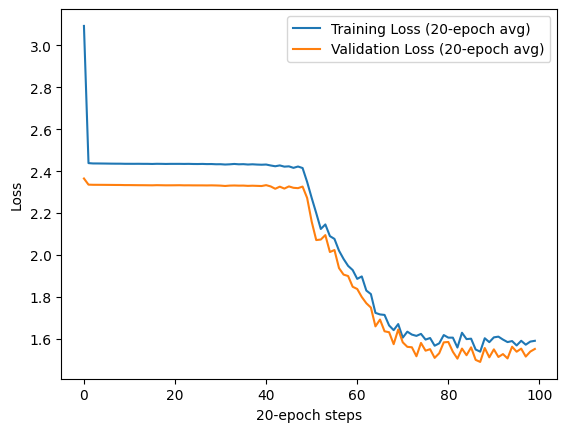

In [19]:
# Save the trained model

autoencoder.save("experimental_STM_spherical_tip_radius_Unnormalized_label_train_loss.h5")
autoencoder.save_weights("experimental_STM_spherical_tip_radius_Unnormalized_label_train_loss.weights.h5")

np.save('train_history_loss.npy',training_data.history)
history=np.load('train_history_loss.npy',allow_pickle='TRUE').item()

print('Model and weight saved.\n')

loss_averaged = [np.mean(training_data.history['loss'][i:i+10]) for i in range(0, len(training_data.history['loss']), 10)]
val_loss_averaged = [np.mean(training_data.history['val_loss'][i:i+10]) for i in range(0, len(training_data.history['val_loss']), 10)]

plt.plot(loss_averaged, label='Training Loss (20-epoch avg)')
plt.plot(val_loss_averaged, label='Validation Loss (20-epoch avg)')
plt.legend()
plt.xlabel('20-epoch steps')
plt.ylabel('Loss')
plt.show()

# Using hackaton's dataset

In [20]:
!pip install pyro5
!pip install scifireaders
!pip install sidpy
!pip install pynsid
!pip install git+https://github.com/pycroscopy/DTMicroscope.git

!run_server_afm

import matplotlib.pylab as plt
import numpy as np
import Pyro5.api
from IPython.display import clear_output, display

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.2/84.2 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.5/105.5 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.9/69.9 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 67.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 70.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 89.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 4.2

In [21]:
!wget https://github.com/pycroscopy/DTMicroscope/raw/boris_dev/DTMicroscope/test/datasets/dset_spm1.h5

--2024-12-17 23:13:52--  https://github.com/pycroscopy/DTMicroscope/raw/boris_dev/DTMicroscope/test/datasets/dset_spm1.h5
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/pycroscopy/DTMicroscope/boris_dev/DTMicroscope/test/datasets/dset_spm1.h5 [following]
--2024-12-17 23:13:52--  https://raw.githubusercontent.com/pycroscopy/DTMicroscope/boris_dev/DTMicroscope/test/datasets/dset_spm1.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22317256 (21M) [application/octet-stream]
Saving to: ‘dset_spm1.h5’

dset_spm1.h5        100%[===================>]  21.28M  --.-KB/s    in 0.1s    

2024-12-17 23:1

In [23]:
uri = "PYRO:microscope.server@localhost:9092" #port for the AFM DT 9092
mic_server = Pyro5.api.Proxy(uri)
import sys

if 'google.colab' in sys.modules:
    mic_server.initialize_microscope("AFM", data_path = r"dset_spm1.h5")
else:
    mic_server.initialize_microscope("AFM", data_path = "../test/datasets/dset_spm1.h5")
mic_server.setup_microscope(data_source = 'Compound_Dataset_1')#upload dataset?
mic_server.get_dataset_info()

[('channels',
  ['Channel_000',
   'Channel_001',
   'Channel_002',
   'Channel_003',
   'Channel_004',
   'Channel_005',
   'Channel_006']),
 ('signals',
  ['HeightRetrace',
   'Amplitude1Retrace',
   'Amplitude2Retrace',
   'Phase1Retrace',
   'Phase2Retrace',
   'FrequencyRetrace',
   'Response']),
 ('units', ['m', 'm', 'm', 'deg', 'deg', 'm', 'a.u.']),
 ('scans', [0, 1, 2, 3, 4, 5]),
 ('spectra', []),
 ('point_clouds', [6])]

In [24]:
#tip_radius
r_tip = np.random.uniform(0.2, 0.8)

#center (tip location)
center = [np.random.uniform(0.2, 0.8), np.random.uniform(0.2, 0.8)]

#kwargs for the blunt needle effect
kwargs = {'effect': 'real_tip', 'r_tip': r_tip, 'center': center}

#several effects can be combined in the mod_dict list
mod_dict = [{'effect': 'real_tip', 'kwargs': kwargs},]

Text(0.5, 1.0, 'Corrupted image')

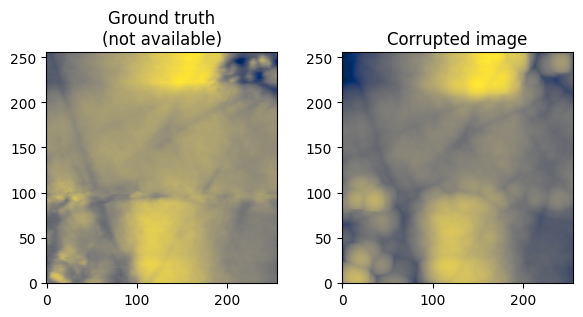

In [25]:
#scan without modification
array_list, shape, dtype  =  mic_server.get_scan(channels=['HeightRetrace',], modification=None)
dat0 =  np.array(array_list, dtype=dtype).reshape(shape)
array_list, shape, dtype = mic_server.get_scan(channels=['HeightRetrace',], modification=mod_dict)
dat1 = np.array(array_list, dtype=dtype).reshape(shape)

fig, ax = plt.subplots(1, 2, figsize=(7,3))

ax[0].imshow(dat0[0].T, cmap='cividis', origin='lower')
ax[0].set_title('Ground truth\n(not available)')
ax[1].imshow(dat1[0].T, cmap='cividis', origin='lower')
ax[1].set_title('Corrupted image')

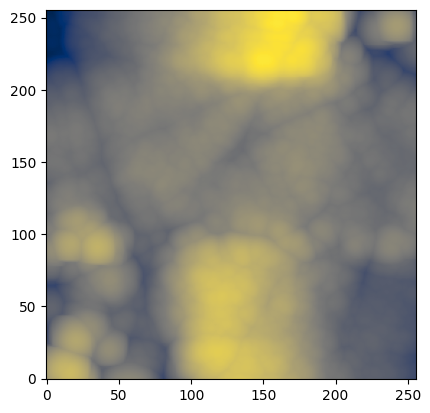

In [26]:
from skimage import transform

test_image = dat1[0].T.copy()
plt.imshow(test_image,cmap='cividis', origin='lower')

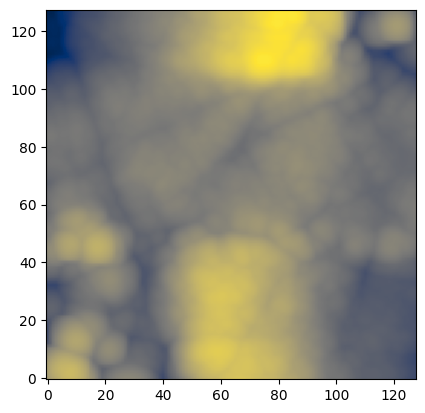

In [27]:
test_image = transform.resize(test_image, (128, 128))
plt.imshow(test_image,cmap='cividis', origin='lower')

In [28]:
test_image = np.expand_dims(test_image, axis=[0,3])
test_image = test_image.astype('float32')
test_image.shape

(1, 128, 128, 1)

In [72]:
ground_truth_img = dat0[0].T.copy()
ground_truth_img = transform.resize(ground_truth_img, (128, 128))
min_val = ground_truth_img.min()
max_val = ground_truth_img.max()
ground_truth_img = (ground_truth_img - min_val) / (max_val - min_val)

In [74]:
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanAbsoluteError

# If you were using MAE directly, provide it as a custom object:
model = load_model(
    "experimental_STM_spherical_tip_radius_Unnormalized_label_train_loss.h5",
    custom_objects={"mae": MeanAbsoluteError()}
)

In [75]:
predicted_image = model.predict(test_image)
predicted_image = predicted_image.squeeze()
min_val = predicted_image.min()
max_val = predicted_image.max()
predicted_image = (predicted_image - min_val) / (max_val - min_val)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


In [76]:
import numpy as np
def calculate_psnr(img1, img2, max_value=255):
    """"Calculating peak signal-to-noise ratio (PSNR) between two images."""
    mse = np.mean((np.array(img1, dtype=np.float32) - np.array(img2, dtype=np.float32)) ** 2)
    if mse == 0:
        return 100
    return 20 * np.log10(max_value / (np.sqrt(mse)))

In [77]:
calculate_psnr(ground_truth_img.squeeze(), predicted_image, max_value=1)

4.043255630016971

In [55]:
!pip install piq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.9/106.9 kB 3.9 MB/s eta 0:00:00


In [80]:
from piq import vif_p
import torch

# images need to be between 0 and 1
# need to be torch tensors


# ground truth
gt_tensor = torch.Tensor(ground_truth_img).unsqueeze(0).unsqueeze(0)
# reconstructed image
torchcorrupted_image = torch.Tensor(predicted_image).unsqueeze(0).unsqueeze(0)

vif_value = vif_p(gt_tensor, torchcorrupted_image)
vif_value

tensor(0.0078)